In [1]:
# Printing CPU infos (CPU allocated : Tesla p-100)
!nvidia-smi

Fri Jun 11 08:19:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set up

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Part 1 - Import Dataset

In [5]:
# Import the dataset from the input folder
df = pd.read_csv('../input/dog-breed-identification/labels.csv')

In [6]:
# Printing the dimensions of the dataset
df.shape

(10222, 2)

In [7]:
# Display the first five rows
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Let's add a new column in this dataframe with the path of each dog image.

In [8]:
# Path to the train folder containing all the images
IMG_TRAIN_PATH = "/kaggle/input/dog-breed-identification/train/"

# Path to the test folder containing all the test images
IMG_TEST_PATH = "/kaggle/input/dog-breed-identification/test/"

# Creating the new dataframe column "img_path"
df = df.assign(img_path = lambda x: IMG_TRAIN_PATH + x['id'] + '.jpg')

In [9]:
df.head()

,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/kaggle/input/dog-breed-identification/train/0...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/kaggle/input/dog-breed-identification/train/0...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/kaggle/input/dog-breed-identification/train/0...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/kaggle/input/dog-breed-identification/train/0...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/kaggle/input/dog-breed-identification/train/0...


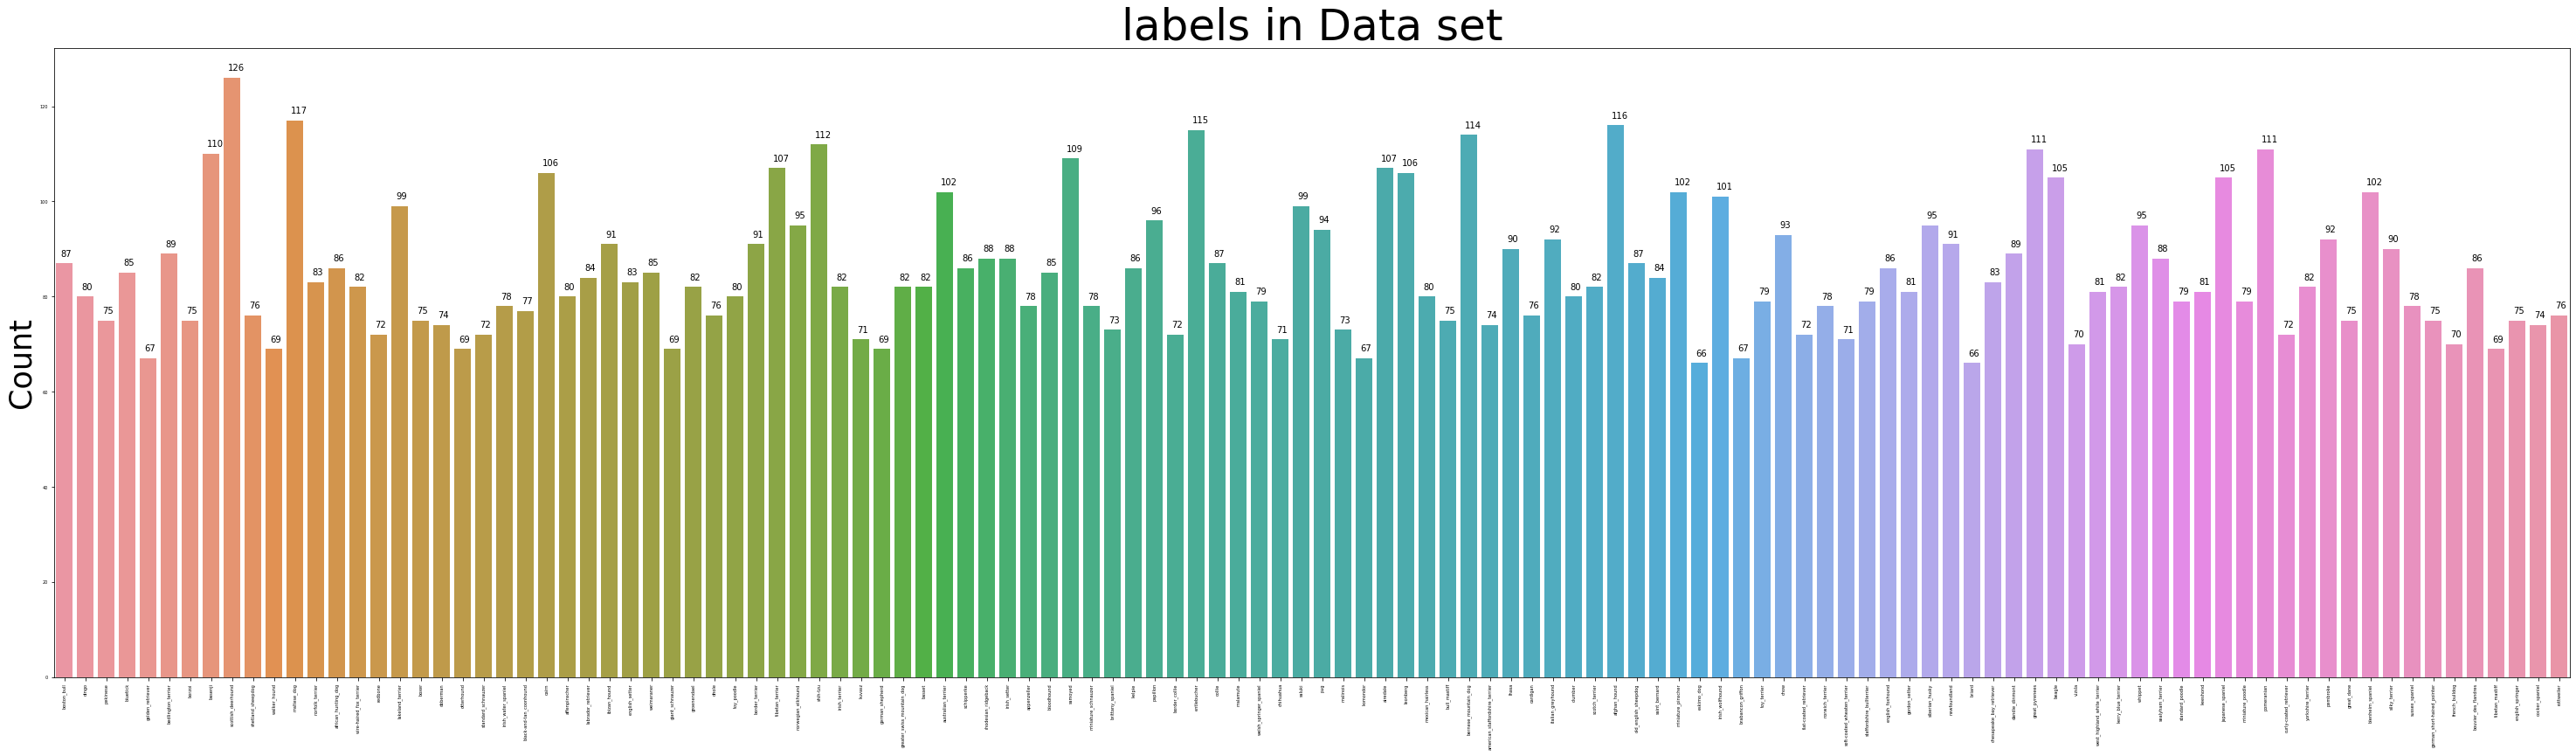

In [10]:
# Checking the number of images we have for each class
fig = plt.figure(figsize = (40, 10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("labels in Data set", fontsize = 50)
sns.countplot(x = "breed", data = df)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 10, color = "black")
plt.xlabel("")
plt.ylabel("Count", fontsize = 35)
plt.tick_params(labelsize = 5)
plt.xticks(rotation = 90)
plt.show()  

# Part 2 - Data preprocessing

## Preprocessing the training set

In [11]:
# Applying transformation to all the images of the training set to avoid overfitting
train_datagen = ImageDataGenerator(
    rescale = 1./255, # rescaling factor. Defaults to None. If None or 0, no rescaling is applied 
    shear_range = 0.2, # Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range = 0.2, # Float or [lower, upper]. Range for random zoom.
    horizontal_flip = True # Boolean. Randomly flip inputs vertically.
)

## Preprocessing the testing set

In [12]:
test_datagen = ImageDataGenerator(
    rescale = 1./255 #Normalization
)

# Part 3 - Splitting the dataset into the training set and the testing set

In [13]:
# Converting all the images to an array and resizing them to a 64x64 image (64 was chosen for less computing time)
X = np.array([img_to_array(load_img(img, target_size = (64,64))) for img in df['img_path'].values.tolist()])
# Encoding the target variable
y = pd.get_dummies(df['breed'])

In [14]:
print(X.shape, y.shape)

(10222, 64, 64, 3) (10222, 120)


In [15]:
from sklearn.model_selection import train_test_split

X_train ,X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8177, 64, 64, 3) (8177, 120)
(2045, 64, 64, 3) (2045, 120)


In [16]:
# Applying transformation to the training set
train_datagen.fit(X_train)
# Applying transformation to the testing set
test_datagen.fit(X_test)

# Part 4 - Building the CNN

## Initialising the CNN

In [17]:
cnn = tf.keras.models.Sequential()

## Step 1 - Convolution

In [18]:
# filters : Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
# kernel_size : An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window, 
# can be a single integer to specify the same value for all spatial dimensions.
# padding : one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding='same' ,activation = 'relu', input_shape = [64, 64, 3]))

In [19]:
# pool_size : integer or tuple of 2 integers, window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window. If only one integer is specified, the same window length will be used for both dimensions.
# strides: Integer, tuple of 2 integers, or None. Strides values. Specifies how far the pooling window moves for each pooling step. If None, it will default to pool_size.
cnn.add(tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2))

### Adding a second convolution layer

In [20]:
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding="same"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

## Step 3 - Flattening

In [21]:
# Reshaping the output of the previous layer into a 1-d matrix ([2,6,89,2,.6,....])
cnn.add(tf.keras.layers.Flatten())

## Step 4 - Full Connection

In [22]:
# Dense layer with 128 units and relu activation function
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))

## Step 5 - Output Layer

In [23]:
# Out layer with 120 units and a softmax activation (total % of the predictions for an observation = 1)
cnn.add(tf.keras.layers.Dense(units = 120, activation = 'softmax'))

# Part 3 - Training the CNN

### Compiling the CNN

In [24]:
# Compiling the model
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 4.2 MB/s 


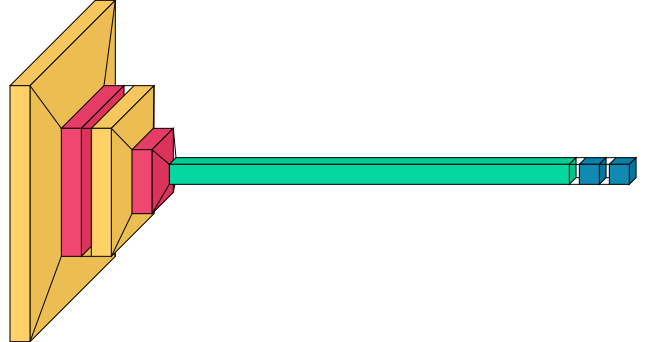

In [26]:
import visualkeras


visualkeras.layered_view(cnn).show() # display using your system viewer
visualkeras.layered_view(cnn, to_file='output.png').show() # write and show
# Print out the neural network shemas
visualkeras.layered_view(cnn)

### Training the CNN on the Training set and evaluating it on the Test set

In [27]:
# fits the model on batches with real-time data augmentation:
history = cnn.fit(X_train, y_train,
        validation_data = (X_test, y_test),
        batch_size = 32,
        epochs = 25,
        verbose = 1
)

Epoch 1/25
256/256 [==============================] - 7s 11ms/step - loss: 11.1345 - accuracy: 0.0073 - val_loss: 4.7873 - val_accuracy: 0.0152
Epoch 2/25
256/256 [==============================] - 2s 9ms/step - loss: 4.7113 - accuracy: 0.0300 - val_loss: 4.8020 - val_accuracy: 0.0161
Epoch 3/25
256/256 [==============================] - 2s 9ms/step - loss: 4.2659 - accuracy: 0.1039 - val_loss: 5.1253 - val_accuracy: 0.0215
Epoch 4/25
256/256 [==============================] - 2s 9ms/step - loss: 3.2414 - accuracy: 0.3041 - val_loss: 5.7447 - val_accuracy: 0.0215
Epoch 5/25
256/256 [==============================] - 2s 9ms/step - loss: 2.2863 - accuracy: 0.5059 - val_loss: 7.2256 - val_accuracy: 0.0240
Epoch 6/25
256/256 [==============================] - 2s 8ms/step - loss: 1.6321 - accuracy: 0.6422 - val_loss: 9.6730 - val_accuracy: 0.0264
Epoch 7/25
256/256 [==============================] - 2s 9ms/step - loss: 1.2248 - accuracy: 0.7356 - val_loss: 11.2001 - val_accuracy: 0.0191
Epo

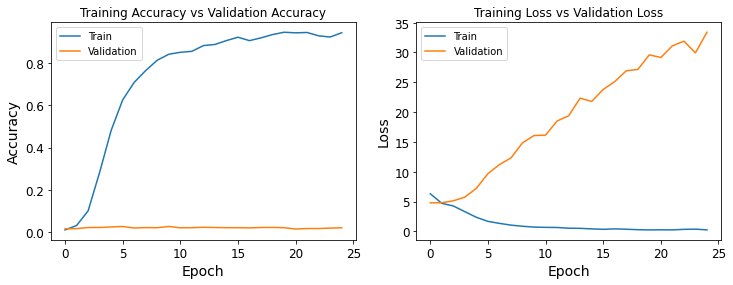

In [28]:
# Plot the learning curve
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()



# Part 4 - Making a prediction

In [29]:
from keras.preprocessing import image
test_image = image.load_img(IMG_TEST_PATH + '000621fb3cbb32d8935728e48679680e.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
print(result.max())

0.99549365


In [30]:
# Make predictions on the testing set
y_pred = cnn.predict(X_test)

In [31]:
y_pred.shape

(2045, 120)

In [32]:
train_loss, train_acc = cnn.evaluate(X_train, y_train)
test_loss, test_acc   = cnn.evaluate(X_test, y_test)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

64/64 [==============================] - 0s 6ms/step - loss: 33.3945 - accuracy: 0.0200
final train accuracy = 95.83 , validation accuracy = 2.00


In [33]:
test_datagen = ImageDataGenerator ( 
    rescale=1/255. # Normalization
)

test_set = test_datagen.flow_from_directory (
    '/kaggle/input/dog-breed-identification',
    target_size = (64,64),
    batch_size = 32,
    classes=['test']
)

Found 10357 images belonging to 1 classes.


# Submission on kaggle

In [34]:
import re
file_list = test_set.filenames
id_list = []
for name in file_list:
    m = re.sub('test/', '', name)
    m = re.sub('.jpg', '', m)
    id_list.append(m)

In [35]:
df_submission = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
df_submission['id'] = id_list
df_submission.iloc[:,1:] = y_pred
df_submission.head()

ValueError: Length of values (2045) does not match length of index (10357)

In [36]:
final_df = df_submission.set_index('id')
final_df.to_csv('Submission.csv')